# Assignment 6

In [5]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

### Set up connection to WRDS...

In [38]:
#sign in

import wrds
db=wrds.Connection(wrds_username='sevogel')
#db.create_pgpass_file()


Loading library list...
Done


### Download and format data

In [39]:
import numpy as np
import datetime
import pandas as pd
import datetime
#################################
# Get data
#################################

# get risk-free rate see http://www.crsp.com/files/treasury_guide_0.pdf
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='2000-01-01'"
            "and mcaldt<='2019-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

#use own index instead
# get index returns
data_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='2000-01-01'"
            "and date<='2019-12-31'", date_cols=['date'])


# get stock returns
crsp_m = db.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2000' and '12/31/2019'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
msf=crsp_m.drop(['shrcd','exchcd'],axis=1)
del(crsp_m) 



###################### taking care of delistings ########################
#########################################################################

## get data on delisting returns

#mse_data = db.raw_sql("""SELECT date, permno, dlret 
#           FROM crsp.mseall
#           WHERE date between '01/01/1970' and '12/31/2018'""", date_cols=['date'])

##check for duplicates
#mse_data = mse_data[~mse_data.duplicated()].copy()
#print('duplicates in data on dlret?')
#print(mse_data.duplicated(subset=['date','permno']).sum(),'\n')

#merge with original dataset

#msf =pd.merge(msf, mse_data, how='left', left_on=['permno','date'],right_on=['permno','date'])

#del(mse_data) 


## Returns adjusted for delisting
#msf['retadj'] = ((1+data['ret'].fillna(0))*(1+msf['dlret'].fillna(0))-1)
#msf.loc[msf[['ret', 'dlret']].isnull().all(axis=1), 'retadj'] = np.nan
#msf['ret']=msf['retadj']

#msf=msf.drop(['dlret','retadj'],axis=1)

######################### continue normally #############################
#########################################################################

#################################
# Define some stuff...
#################################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

#variables
msf['permno'] = msf['permno'].astype(int)
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['const'] = 1
msf.sort_values(['permno','date'])

msf['size_lag']= msf.groupby('permno')['size'].shift(1).to_frame()

obs=msf[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
msf = pd.merge(msf, obs, how='left', left_on=['permno'],right_on=['permno'])



#################################
# Compute excess returns
#################################
data_index = pd.merge(data_index, Rf, how='left', left_on=['date'],right_on='date')
data_index['mprem']=(data_index['vwretd']-data_index['rf'])
data = pd.merge(msf, data_index, how='left', left_on=['date'],right_on='date')
data['exret']=data['ret']-data['rf']





print('duplicates in data on returns?')
print(data.duplicated(subset=['date','permno']).sum(),'\n')

print(' How many obervations do we have in a month?')
print('max:', max(data[['date','const']].groupby('date').sum()['const'].values))
print('min:', min(data[['date','const']].groupby('date').sum()['const'].values))

print('\n How often do we observe a given stock?')
print('max:', max(data['obs'].values))
print('min:', min(data['obs'].values))

print('\n Let us limit our attention to stocks we observe often enough...')



duplicates in data on returns?
0 

 How many obervations do we have in a month?
max: 2310
min: 1403

 How often do we observe a given stock?
max: 240
min: 1

 Let us limit our attention to stocks we observe often enough...


In [40]:
# save data
data.to_csv('data1.csv', sep=';', index=False)
data_index.to_csv('data1_index.csv', sep=';', index=False)
Rf.to_csv('Rf1.csv', sep=';', index=False)

In case memory crashes, take a break here and load only the necessary data below...

In [50]:
import numpy as np
import pandas as pd

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
    
# load data
data = pd.read_csv("data1.csv", sep=';')
data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')

data_index = pd.read_csv("data1_index.csv", sep=';')
data_index['date']=pd.to_datetime(data_index['date'], format='%Y-%m-%d')

Rf = pd.read_csv("Rf1.csv", sep=';')
Rf['date']=pd.to_datetime(Rf['date'], format='%Y-%m-%d')


vwrets_mkt=data[data['date']>'1972-01-31'].groupby(['date']).apply(wavg, 'exret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})
print('A quick consistency check! \n')
print('The average value-weighted excess return in the sample is ', vwrets_mkt['vwret'].mean(),'.\n')
print('The value-weighted return from CRSP is ', data_index[data_index['date']>'1972-01-31']['mprem'].values.mean(),'.\n')
print('The average risk-free rate is ', Rf['rf'].mean(),'.\n')

print('Looks alright!')

A quick consistency check! 

The average value-weighted excess return in the sample is  0.004883993035746762 .

The value-weighted return from CRSP is  0.00451006587858147 .

The average risk-free rate is  0.0013152996576685293 .

Looks alright!


In [45]:
# If price data is used, one needs to use the absolute values (some observations are negative)
data['prc']=np.abs(data['prc'])

In [54]:
data=data[data.obs==240]

#data = data[(data['ret'].notnull()) & (data['size_lag'].notnull())]

print(' How many obervations do we have now in a year?')
print('max:', max(data[['date','const']].groupby('date').sum()['const'].values))
print('min:', min(data[['date','const']].groupby('date').sum()['const'].values))

print('\n How often do we observe a given stock now?')
print('max:', max(data['obs'].values))
print('min:', min(data['obs'].values))

 How many obervations do we have now in a year?
max: 639
min: 639

 How often do we observe a given stock now?
max: 240
min: 240


### Calculate betas for the whole sample period, get portfolio returns

In [59]:
print(data[['permno','prc']][data['ret'].isnull()].drop_duplicates())
print(data[['permno','prc']][data['prc'].isnull()].drop_duplicates())
print(data[['permno','prc']][data['shrout'].isnull()].drop_duplicates())

        permno      prc
183760   64899      NaN
295923   84302      NaN
335890   87541  12.0625
        permno  prc
183760   64899  NaN
295923   84302  NaN
Empty DataFrame
Columns: [permno, prc]
Index: []



 (a) betas and returns: whole sample and equally-weighted returns:


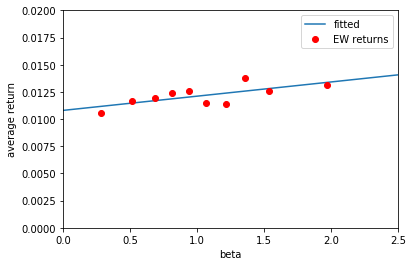

The market risk premium is  0.00451 .

The actual slope is  0.00131 .



In [48]:

#drop some stuff that is not needed anymore
#data=data.drop(['size','shrout','prc'],axis=1)

#################################
# Compute betas
#################################

############ for the whole sample #############################
covariances=data.groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar'})
mvar=data.groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})

#merge new values with original dataset
data = pd.merge(data, covariances, how='left', left_on=['permno'],right_on='permno')
data = pd.merge(data, mvar, how='left', left_on=['permno'],right_on='permno')

# cumpute the betas
data['beta']=data['covar']/data['varm']

#drop some stuff that is not needed anymore
data=data.drop(['covar','vwretd', 'varm'],axis=1)

#################################
# Compute deciles
#################################

data['decile']=1+data[['beta','date']].groupby('date')\
.transform(lambda x: pd.qcut(x, 10, labels=False))


data = data.sort_values(['decile', 'date'])



#################################
# Compute Equally Weighted Returns and Betas #
#################################

# in order to keep track of the dates, it is convenient to define an index
data=data.set_index('date')  

# equally weigthed return
ewrets=data.groupby(['decile','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})

ewbetas=data.groupby(['decile']).apply(wavg, 'beta','const')\
.to_frame().reset_index().rename(columns={0: 'beta'})

#avgewrets=ewrets.groupby(['decile']).apply(wavg, 'ewret','const')\
#.to_frame().reset_index().rename(columns={0: 'ewret_avg'})
avgewrets=ewrets.groupby(['decile']).mean().reset_index()

# convert data back to what we had before
data=data.reset_index()



#################################
# Fama-McBeth #
#################################
import statsmodels.formula.api as sm

regdata = pd.merge(avgewrets, ewbetas, how='left', left_on=['decile'],right_on='decile')

result1 = sm.ols(formula="ewret ~ beta", data=regdata).fit()



#make plots of returns vs. beta
import matplotlib.pyplot as plt
#R0=Rf[Rf['date']>'1979-01-31']['rf'].mean()
MP=data_index[data_index['date']>'1979-01-31']['mprem'].values.mean()

beta_values = np.linspace(0,2.5,100)



# first plot
#CAPM_line = R0+MP*beta_values
fitted_line=result1.params.values[0]+result1.params.values[1]*beta_values


#plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewbetas['beta'].values,avgewrets['ewret'].values,'ro')
#plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2.5)
plt.ylim(0, 0.02)
plt.legend(['fitted','EW returns'], loc=0)
print('\n (a) betas and returns: whole sample and equally-weighted returns:')
plt.savefig('ret_beta_full.png', format='png')

plt.show()
print('The market risk premium is ',np.round(MP,5) ,'.\n')
print('The actual slope is ',np.round(result1.params.values[1],5),'.\n')

# Splitting the sample


 (a) betas and returns: second-half equally-weighted returns vs. first-half betas:


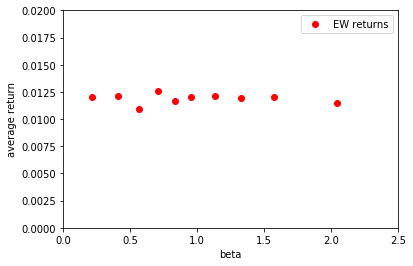


 (a) betas and returns: second-half betas vs. first-half betas:


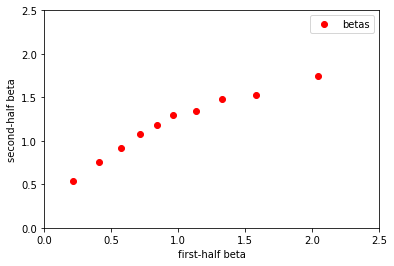

In [49]:
#define dummy variable for two parts of the sample

data['half']=2
data.loc[data['date']<'01-01-2010','half']=1

#################################
# Compute betas
#################################

############ for the whole sample #############################
covariances1=data[data['date']<'01-01-2010'].groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar1'})
mvar1=data[data['date']<'01-01-2010'].groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm1'})
covariances2=data[data['date']>='01-01-2010'].groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar2'})
mvar2=data[data['date']>='01-01-2010'].groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm2'})

#merge new values with original dataset
betas = pd.merge(covariances1, mvar1, how='left', left_on=['permno'],right_on='permno')
betas = pd.merge(betas, covariances2, how='left', left_on=['permno'],right_on='permno')
betas = pd.merge(betas, mvar2, how='left', left_on=['permno'],right_on='permno')

# cumpute the betas
betas['beta1']=betas['covar1']/betas['varm1']
betas['beta2']=betas['covar2']/betas['varm2']

#drop some stuff that is not needed anymore
betas=betas.drop(['covar1', 'varm1','covar2', 'varm2'],axis=1)
data= pd.merge(data, betas, how='left', left_on=['permno'],right_on='permno')


#################################
# Compute deciles
#################################

data['decile']=1+data[['beta1','date']].groupby('date')\
.transform(lambda x: pd.qcut(x, 10, labels=False))


data = data.sort_values(['decile', 'date'])

#################################
# Compute Equally Weighted Returns and Betas #
#################################

# in order to keep track of the dates, it is convenient to define an index
data=data.set_index('date')  

# equally weigthed return
ewrets2=data[data['half']==2].groupby(['decile','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})

ewbetas1=data[data['half']==1].groupby(['decile']).apply(wavg, 'beta1','const')\
.to_frame().reset_index().rename(columns={0: 'beta1'})

ewbetas2=data[data['half']==2].groupby(['decile']).apply(wavg, 'beta2','const')\
.to_frame().reset_index().rename(columns={0: 'beta2'})



#avgewrets=ewrets.groupby(['decile']).apply(wavg, 'ewret','const')\
#.to_frame().reset_index().rename(columns={0: 'ewret_avg'})
avgewrets2=ewrets2.groupby(['decile']).mean().reset_index()

# convert data back to what we had before
data=data.reset_index()


##### make plots

plt.plot(ewbetas1['beta1'].values,avgewrets2['ewret'].values,'ro')
#plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2.5)
plt.ylim(0, 0.02)
plt.legend(['EW returns'], loc=0)
print('\n (a) betas and returns: second-half equally-weighted returns vs. first-half betas:')
plt.savefig('ret2_beta1.png', format='png')
plt.show()


plt.plot(ewbetas1['beta1'].values,ewbetas2['beta2'].values,'ro')
#plt.plot(0,R0,'bo')
plt.xlabel('first-half beta')
plt.ylabel('second-half beta')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.legend(['betas'], loc=0)
print('\n (a) betas and returns: second-half betas vs. first-half betas:')
plt.savefig('beta2_beta1.png', format='png')
plt.show()

